### This notebook serves to better organize the work from Backtesting.ipynb

In [31]:
import pandas as pd
import numpy as np
from collections import deque
import json
import requests
import matplotlib.pyplot as plt
from useful_functions import crypto_raw_to_pandas, parse_all_book_updates, parse_all_trade_prices, binary_price
from Vol import Vol
import matplotlib.pyplot as plt
from OrderBook import OrderBook

## IDEA -> ratio of crypto volatility to option volatility

In [34]:
class Strategy:
    def __init__(self):
        pass

    def on_warmup(self, timestamp, crypto_price, order_book):
        """Called during warm-up period before official backtest start."""
        raise NotImplementedError
        pass

    def on_update(self, timestamp, crypto_price, order_book):
        """Main decision point — return actions or orders."""
        raise NotImplementedError
        pass

    def on_trade(self, trade):
        """Optional: Handle trade events if they matter."""
        pass

    def get_state(self) -> dict:
        """Return current strategy metrics for logging."""
        raise NotImplementedError

In [45]:
def backtest_market(crypto_data_filepath, crypto_data_filename, crypto_symbol, 
                    market_data_filepath, market_slug,
                    unix_start_time, unix_end_time, 
                    warm_up_duration, # how long to warm the models up before the start time
                    strategy:Strategy, # the strategy that is used 
                    time_precision: int = 13 # default milliseconds unix precision -> convert all timestamps to this
                    ):
        
        # TODO -> do we need to sort trades and book updates just in case?
        # TODO -> Need to iterate through the timestamps of all of the market events to change the precision to the expected precision
        # TODO -> need to add reacting to trades 

        if time_precision < 10:
            raise ValueError("time precision can't be less than 10 (secondly)")

        # ensure all times have same precision
        def adjust_precision(timestamp:int, precision:int) -> int:
            return int(np.ceil(timestamp * 10**(precision - len(str(timestamp)))))
        
        unix_start_time = adjust_precision(unix_start_time, time_precision)
        unix_end_time = adjust_precision(unix_end_time, time_precision)
        # warm_up_duration = adjust_precision(warm_up_duration, time_precision) -> can't because it's a time difference
        
        # read in crypto data
        all_coin_df = crypto_raw_to_pandas(f"{crypto_data_filepath}{crypto_data_filename}")
        coin_df = all_coin_df[all_coin_df['symbol'] == crypto_symbol].sort_values(by="unix_timestamp").reset_index(drop=True)

        # get token IDs of the market
        url = "https://gamma-api.polymarket.com/events"
        response = requests.get(url, params={"slug": market_slug})
        yes_token_id, no_token_id = json.loads(response.json()[0]['markets'][0]['clobTokenIds'])

        # get order book updates from our historical data
        messages = []
        with open (f"{market_data_filepath}{market_slug}.jsonl") as f:
            for line in f:
                line_data = json.loads(line)
                messages.append(line_data)

        order_book_updates = parse_all_book_updates(messages)
        yes_book_updates = [update for update in order_book_updates if update['asset_id'] == yes_token_id]
        no_book_updates = [update for update in order_book_updates if update['asset_id'] == no_token_id]
        
        # get trades from both yes and no book perspectives
        trades_yes_perspective, trades_no_perspective = parse_all_trade_prices(messages, yes_token_id, no_token_id)
        
        # create queues for time arrival
        crypto_price_queue = deque(zip(coin_df['unix_timestamp'], coin_df['value']))
        market_update_queue = deque(yes_book_updates)
        # trade_queue = deque(trades_yes_perspective)  # TODO -> add trade data?

        warm_up_start_time = unix_start_time - warm_up_duration
        order_book = OrderBook()

        warm_up_data = []
        backtest_data = []

        # flush any data that is before the warm up start window
        latest_crypto_price = np.nan
        while crypto_price_queue and crypto_price_queue[0][0] < warm_up_start_time:
            _, latest_crypto_price = crypto_price_queue.popleft()
        while market_update_queue and market_update_queue[0]['timestamp'] < warm_up_start_time:
            market_update_queue.popleft()

        # warm up strategy
        while crypto_price_queue or market_update_queue:
            # pick whichever event occurs next
            next_times = []
            if crypto_price_queue:
                next_crypto_time, _ = crypto_price_queue[0]
                next_times.append(next_crypto_time)
            
            if market_update_queue:
                next_market_time = market_update_queue[0]['timestamp']
                next_times.append(next_market_time)
            
            next_timestamp = min(next_times)

            if next_timestamp >= unix_start_time:
                # exit once we hit backtest time
                break
                
            # update crypto price if needed
            if crypto_price_queue and crypto_price_queue[0][0] == next_timestamp:
                _, latest_crypto_price = crypto_price_queue.popleft()
            
            # update order book if needed
            market_updates = []
            while market_update_queue[0]['timestamp'] == next_timestamp:
                market_update = market_update_queue.popleft()
                market_updates.append(market_update)
            order_book.batch_update(market_updates)

            strategy.on_warmup(next_timestamp, latest_crypto_price, order_book)
            warm_up_data.append({
                    "timestamp": next_timestamp,
                    **strategy.get_state()
                }
            )
            
        # run the backtest
        while crypto_price_queue or market_update_queue:
            
            # pick whichever event occurs next
            next_times = []
            if crypto_price_queue:
                next_crypto_time, _ = crypto_price_queue[0]
                next_times.append(next_crypto_time)
            
            if market_update_queue:
                next_market_time = market_update_queue[0]['timestamp']
                next_times.append(next_market_time)
            
            next_timestamp = min(next_times)

            if next_timestamp > unix_end_time:
                # exit once we hit end of backtest
                break
                
            # update crypto price if needed
            if crypto_price_queue and crypto_price_queue[0][0] == next_timestamp:
                _, latest_crypto_price = crypto_price_queue.popleft()
            
            # update order book if needed
            market_updates = []
            while market_update_queue[0]['timestamp'] == next_timestamp:
                market_update = market_update_queue.popleft()
                market_updates.append(market_update)
            order_book.batch_update(market_updates)

            strategy.on_update(next_timestamp, latest_crypto_price, order_book)
            backtest_data.append({
                    "timestamp": next_timestamp,
                    **strategy.get_state()
                }
            )    
        
        return warm_up_data, backtest_data

In [46]:
class DataTrackStrategy(Strategy):
    def __init__(self, market_strike_set_time, market_resolve_time, time_precision, effective_memory=300):
        self.crypto_price = np.nan

        self.market_strike_set_time = market_strike_set_time
        self.market_resolve_set_time = market_resolve_time

        secs_in_year = 3.154e+7
        self.annualize_factor = secs_in_year * 10**(time_precision - 10)

        self.strike_price = np.nan
        self.resolve_price = np.nan

        self.theo_price = np.nan

        self.order_book = None
        self.vol_tracker = Vol(effective_memory=effective_memory) # 5 minutes of effective memory?
        
    def on_warmup(self, timestamp, crypto_price, order_book):
        """Called during warm-up period before official backtest start."""
        #TODO -> this assumes if the crypto price is the same, then it wasn't an update for vol
        if crypto_price != self.crypto_price:
            self.vol_tracker.update_vol_from_price(self.crypto_price)
            self.crypto_price = crypto_price

        self.order_book = order_book
        
        if timestamp == self.market_strike_set_time:
            self.strike_price = crypto_price
        
        if timestamp == self.market_resolve_set_time:
            self.resolve_price = crypto_price

    def on_update(self, timestamp, crypto_price, order_book):
        """Main decision point — return actions or orders."""
        
        if crypto_price != self.crypto_price:
            self.vol_tracker.update_vol_from_price(self.crypto_price)
            self.crypto_price = crypto_price

        self.order_book = order_book
        
        T = (self.market_resolve_set_time - timestamp) / self.annualize_factor
        self.theo_price = binary_price(self.crypto_price, self.strike_price,
                                    T, self.vol_tracker.vol, r=4.2
                        )
        
        if timestamp == self.market_strike_set_time:
            self.strike_price = crypto_price
        
        if timestamp == self.market_resolve_set_time:
            self.resolve_price = crypto_price

    def on_trade(self, trade):
        """Optional: Handle trade events if they matter."""
        pass

    def get_state(self):
        """Return current strategy metrics for logging."""
        return{
            "crypto_price": self.crypto_price,
            "vol": self.vol_tracker.vol,
            "market_spread": self.order_book.spread,
            "best_bid": self.order_book.best_bid,
            "best_ask": self.order_book.best_ask,
            "theo_price": self.theo_price,
            "mid_price": self.order_book.mid,
            "lwm_price": self.order_book.lwm
        }

In [47]:
## backtest inputs
crypto_data_filepath = "btc_and_price_data/"
crypto_data_filename = "chainlink_crypto_prices_2025-10-30.jsonl"
market_data_filepath = "btc_and_price_data/"
crypto_symbol = "btc/usd"
market_slug = "btc-updown-15m-1761786000"
unix_start_time = 1_761_786_000_000
unix_end_time = unix_start_time + 900_000 # buffer
warm_up_duration = 900_000 # 5 minutes in milliseconds?
time_precision = 13 # in millisecond format (10 = second format)
strategy = DataTrackStrategy(unix_start_time, unix_end_time, time_precision=13, effective_memory=300)

warm_up_data, backtest_data = backtest_market(crypto_data_filepath, crypto_data_filename, crypto_symbol,
                                market_data_filepath, market_slug,
                                unix_start_time, unix_end_time,
                                warm_up_duration,
                                strategy,
                                time_precision=13 
                            )

[CROSS WARNING] Book crossed at 1761786625422: bid=0.57, ask=0.57


/Users/willneuner/Desktop/FINTECH535/crypto-pred-mrkt-arb/useful_functions.py:13: RuntimeWarning: divide by zero encountered in scalar divide
  if T <= 0:


In [48]:
backtest_df = pd.DataFrame(backtest_data)
# backtest_df.dropna() # once we have market data, then we can begin tracking everything 

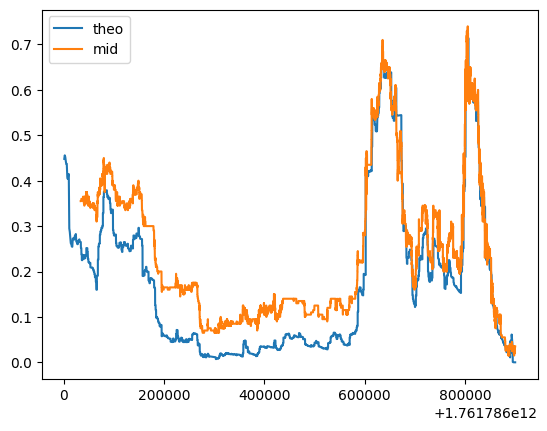

In [49]:
backtest_df = backtest_df[(backtest_df['timestamp']>=unix_start_time) & (backtest_df['timestamp']<=unix_end_time)]
plt.plot(backtest_df['timestamp'], backtest_df['theo_price'], label="theo")
plt.plot(backtest_df['timestamp'], backtest_df['mid_price'], label="mid")
# plt.plot(backtest_df['timestamp'], backtest_df['lwm_price'], label="lwm")
# plt.plot(backtest_df['timestamp'], backtest_df['market_spread'], label="spread")
plt.legend()

### What I noticed: Chainlink severely underestimates the volatility of the markets, as it is naturally a smoothed metric from all of the different exchanges. We should compare results from many trials to see 